# Objective
### The aim of this is to fit the reconstructed and the fully sampled data for the case of real MRI scan data

The basis used here is generated on the estimated T1,T2 from the experimental data. So the basis is evaluated from epg simulations run on the estimated T1,T2 maps.


The basis data used here is taken from the subject 2 data in here


In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import sigpy.plot as pl
#import scipy.io
#from scipy.optimize import curve_fit, check_grad
import utils
#reload(utils)#dont know its uitlity right now, will update later

# import sys#this helps with reading data from multiple places
# sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
# sys.path.insert(0, 'bart/python')#do we need bart here right now
# sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function

# import t1t2shuffle as t2sh
# import epg
# import cfl #useful in data storage and reading, dont need it right now
# import time

from tqdm import tqdm

In [2]:
#some function definitions that will be used later
def nrmse(x1, x2):
    return np.linalg.norm(x1.ravel() - x2.ravel()) / np.linalg.norm(x1.ravel())

#spin echo signal evolution definition
def spin_echo(T1T2_vals, TE, TR):
    return np.exp(-TE / T1T2_vals[1,:]) * (1 - np.exp(-(TR-TE)/T1T2_vals[0,:]))

#inverse recovery spin echo used for generating T1 and T2 FLAIR images
def IR_spin_echo(T1T2_vals, TE, TR, TI):
    return (1 - 2 * np.exp(-(TI)/T1T2_vals[0,:]) + np.exp(-TR/T1T2_vals[0,:]))*np.exp(-TE / T1T2_vals[1,:]) 

In [3]:
#loading the simulated signal evolutions
X_sim = np.load('X_simulated_experimentalT1_T2.npy')#load the simulated epg curves for 390 TEs and mask2 of the data
print(X_sim.shape)
basis = np.load('basis_experimentalT1_T2.npy')#load the basis matrix
print(basis.shape)
K = 5  #the number of basis choosen for reconstruction
Phi = basis[:,:K]
print(Phi.shape)

(48, 35818)
(48, 48)
(48, 5)


In [4]:
T2_values = np.load('Subject2_T2_vals_experimental.npy')#loading the experimental evaluated T2 values
T1_values = np.load('Subject2_T1_vals_experimental.npy')
mask = np.load('Subject2_mask_experimental.npy')
T1T2_vals = np.zeros((2,len(T1_values)))

T1T2_vals[0,:] = T1_values 
T1T2_vals[1,:] = T2_values
print(T1T2_vals.shape)

(2, 35818)


In [5]:
# #loading the different true contrast images
# True_contrast_T1_FLAIR = np.load('96ETL_True_contrast_T1_FLAIR.npy')
# True_contrast_T2_FLAIR = np.load('96ETL_True_contrast_T2_FLAIR.npy')
# True_contrast_T1_image = np.load('96ETL_True_contrast_T1_image.npy')
# True_contrast_T2_image = np.load('96ETL_True_contrast_T2_image.npy')

In [6]:
#data from the simulation data

# recon1 = np.load('32recon1.npy')
# fully_image1 = np.load('32Fully_sampled_image1.npy')
# GT_coeff_img = np.load('32GT_coeff_img.npy')
# print('recon1 shape: ',recon1.shape, 'data type: ', recon1.dtype)
# print('fully_image1 shape:', fully_image1.shape, 'data type: ',fully_image1.dtype)
# print('GT_coeff_img shape:',GT_coeff_img.shape, 'data type: ',GT_coeff_img.dtype)

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
class Network(nn.Module):
    def __init__(self,basis_K,out_dim=2):
        super().__init__()
        
        self.basis_K = basis_K
        self.out_dim = out_dim#the default out_dim = 2, so that we can train complex NNs
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(self.basis_K, 32,bias=False)
        self.fc2 = nn.Linear(32, 8,bias=False)
        self.fc3 = nn.Linear(8, self.out_dim,bias=False)
        #print(self)
        # Define sigmoid activation and softmax output 
        #self.sigmoid = nn.Sigmoid()
        #self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
#try to incorporate the training function as well into the class definition, need to look into this later    
    
#A = training input
#Y_se = training output
#lr = learning rate
#epochs = training epochs


In [8]:
def nrmse_torch(x1, x2):
    #for some reason torch.ravel is not working so a workaround is this
    return torch.norm( x1.view(-1) - x2.view(-1) ) / torch.norm( x1.view(-1))


In [9]:
#new training function, incorporates validation and random shufflling indexes
def training(model, epochs, lr, batch_size, Training_input, Training_output):
    rand_idx = np.random.permutation(Training_input.shape[0])#randomly shuffle the data

    data_length = len(Training_input)

    train_set = Training_input[rand_idx]
    train_output = Training_output[rand_idx].squeeze()

    losses_train = np.zeros(epochs)
    number_of_batches = data_length//batch_size
    nrmse_losses = torch.zeros((epochs,number_of_batches//1000 +1 ) )
    #nrmse_losses = torch.zeros(epochs)

    criterion = nn.MSELoss()#loss definition
    optimizer = optim.Adam(model.parameters(), lr=lr)#right now choosing Adam, other option is SGD
    
    for e in tqdm(range(epochs), total=epochs, leave=True):
        running_loss = 0
        rand_idx2 = np.random.permutation(train_set.shape[0])#randomly shuffle the data in each epoch
        #for idx in tqdm( range(number_of_batches), total = number_of_batches, leave = True):
        for idx in range(number_of_batches):
            #generate the batch data
            batch_data = train_set[rand_idx2[idx*batch_size:(idx+1)*batch_size]]
            batch_out = train_output[rand_idx2[idx*batch_size:(idx+1)*batch_size]]

            # Training pass
            optimizer.zero_grad()
            output = model(batch_data)
            loss = criterion(output, batch_out)
            loss.backward()
            optimizer.step()  
            running_loss += loss.item()
            if(idx%1000==0):
                learnd_output = model(Training_input)
                nrmse_losses[e,idx//1000] = nrmse_torch(learnd_output,Training_output)
            #print('T1 image nrmse:-', nrmse_torch(learnd_output,Training_output))

        losses_train[e] = running_loss/len(train_output)
        #learnd_output = model(Training_input)
        #nrmse_losses[e] = nrmse_torch(learnd_output,Training_output)

    return losses_train, nrmse_losses.view(-1).detach().numpy()

  0%|          | 0/3 [00:00<?, ?it/s]/home/ubuntu/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 3/3 [01:05<00:00, 21.68s/it]


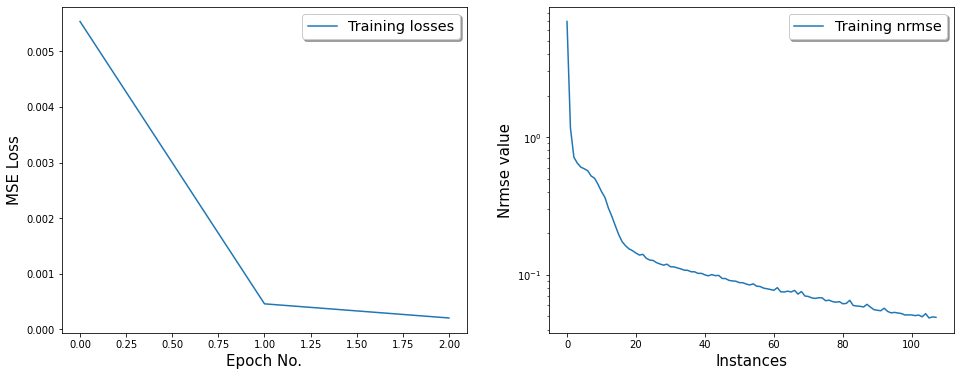

In [10]:

#generating the training input and outputs for the NN to learn, this is for the real valued case
Y_T1_image = spin_echo(T1T2_vals, 10, 250)#find the actual spin evolution through EPG algorithm, approximated through that spin echo function defined earlier
Y_T2_image = spin_echo(T1T2_vals, 110, 8000)  

Y_T1_FLAIR = IR_spin_echo(T1T2_vals, 10, 2100, 880)
Y_T2_FLAIR = IR_spin_echo(T1T2_vals, 110, 8000, 1600)

A = np.dot(Phi.T, X_sim).T#find the projection coefficinets, shape would be (37000,5) as 37000 T1T2 vals and 5 basis
A_magnitude = np.amax(abs(A),axis=1)
A_new = A/np.amax(abs(A),axis=1)[:,None]#normaliIng the data so that we have better fitting
Training_input_real = torch.from_numpy(A_new).float()
Training_output_T1_image_real = torch.from_numpy(Y_T1_image).float()
Training_output_T2_image_real = torch.from_numpy(Y_T2_image).float()
Training_output_T1_FLAIR_real = torch.from_numpy(Y_T1_FLAIR).float()
Training_output_T2_FLAIR_real = torch.from_numpy(Y_T2_FLAIR).float()


lr = 0.00005
batch_size = 1
epochs = 3
model_T1_image_real = Network(basis_K = K,out_dim=1)
[losses_train1,nrmse_losses] = training(model_T1_image_real,epochs,lr,batch_size,Training_input_real,Training_output_T1_image_real)


plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(losses_train1,label='Training losses')
#plt.plot(losses_valid,label='validation losses')
plt.xlabel('Epoch No.',fontsize=15)
plt.ylabel('MSE Loss',fontsize=15)
plt.legend(loc='best', shadow=True, fontsize='x-large')

plt.subplot(1,2,2)
plt.plot(nrmse_losses,label='Training nrmse')
plt.xlabel('Instances',fontsize=15)
plt.ylabel('Nrmse value',fontsize=15)
plt.yscale('log')
plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()


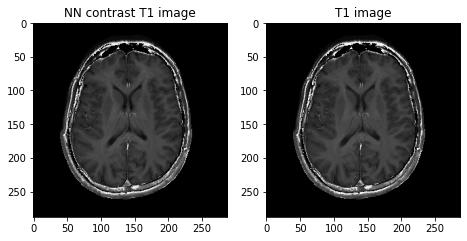

In [11]:
output1 = model_T1_image_real(Training_input_real)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
Im_synthetic[np.nonzero(mask)] = ttt#*A_magnitude
NN_T1_image = Im_synthetic


plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax=.8)
plt.title('NN contrast T1 image')

#plt.subplot(1,4,2)
#plt.imshow(np.abs(True_contrast_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= 0.5)
#plt.imshow(np.abs(True_contrast_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax=.0008)
#plt.title('True contrast (Eq) T1 image')


plt.subplot(1,4,2)
Im_synthetic = np.zeros([288,288])
ttt = Training_output_T1_image_real.detach().numpy().squeeze() 
Im_synthetic[np.nonzero(mask)] = np.abs((ttt))#*A_magnitude
NN_T1_image = Im_synthetic
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax=0.8)
plt.title('T1 image')

plt.show()

In [12]:
#generating data for feeding to the neural network to train for complex inputs

A = np.dot(Phi.T, X_sim).T#find the projection coefficinets, shape would be (37000,3) as 37000 T1T2 vals and 3 basis
#A_abs = A/np.amax(abs(A),axis=1)[:,None]#normalizing the data so that we have better fitting
print(np.max(np.abs(A)))
print(np.min(np.abs(A)))

A_abs = A/np.max(np.abs(A))
#abs(A)*exp(j*2*pi*rand())
#A_rand_phase = np.exp(1j*2*np.pi*np.random.rand(len(A[:,0]),len(A[0,:])))#random phase
#A_complex = A_abs*A_rand_phase#complex values
#A_phase = np.exp(1j*np.pi*0.25)#pi/4 phase to each coefficient
A_phase = np.exp(1j*2*np.pi*np.random.rand(len(A[:,0])))#same phase to all the coefficients of a single pixel
A_phase_K = np.tile(A_phase,(K,1)).T#repeat same phase for all the basis
A_complex = A_abs*A_phase_K#complex values
A_NN_data = np.concatenate((np.real(A_complex),np.imag(A_complex)),axis=1)#differentiatie real and complex values for the NN
Training_input = torch.from_numpy(A_NN_data).float()

0.9997830146719949
1.02127201012189e-06


In [13]:
#generating the training input and outputs for the NN to learn
#give same phase to the output as well, here
Y_T1_image = A_phase*spin_echo(T1T2_vals, 10, 250)#find the actual spin evolution through EPG algorithm, approximated through that spin echo function defined earlier
Y_T2_image = A_phase*spin_echo(T1T2_vals, 110, 8000)  

Y_T1_FLAIR = A_phase*IR_spin_echo(T1T2_vals, 10, 2100, 800)
Y_T2_FLAIR = A_phase*IR_spin_echo(T1T2_vals, 100, 8000, 1600)

#A = np.dot(Phi.T, X_sim).T#find the projection coefficinets, shape would be (37000,5) as 37000 T1T2 vals and 5 basis
#A_new = A/np.amax(abs(A),axis=1)[:,None]#normaliIng the data so that we have better fitting
#Training_input = torch.from_numpy(A_new).float()
Training_output_T1_image = torch.from_numpy(np.hstack((np.real(Y_T1_image)[:,None],np.imag(Y_T1_image)[:,None]))).float()
Training_output_T2_image = torch.from_numpy(np.hstack((np.real(Y_T2_image)[:,None],np.imag(Y_T2_image)[:,None]))).float()
Training_output_T1_FLAIR = torch.from_numpy(np.hstack((np.real(Y_T1_FLAIR)[:,None],np.imag(Y_T1_FLAIR)[:,None]))).float()
Training_output_T2_FLAIR = torch.from_numpy(np.hstack((np.real(Y_T2_FLAIR)[:,None],np.imag(Y_T2_FLAIR)[:,None]))).float()


In [14]:
#setting the parameters for the complex NNs and their respective learning
#K = 3
lr = 0.001
batch_size = 1

In [15]:
Training_input.shape

torch.Size([35818, 10])

100%|██████████| 5/5 [02:01<00:00, 24.34s/it]


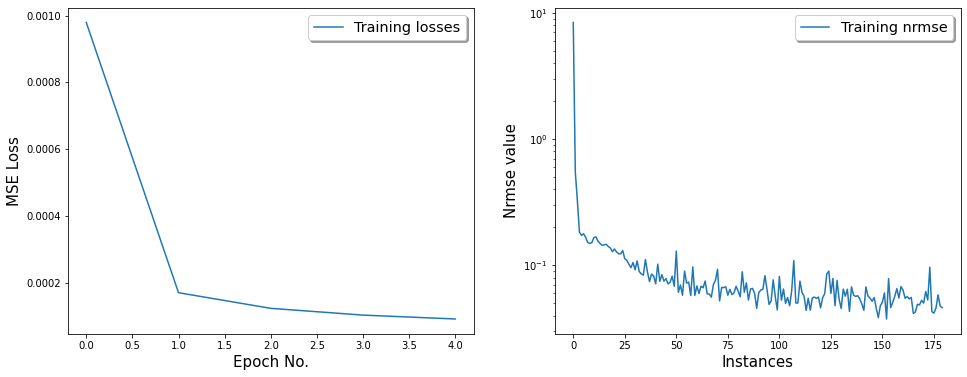

In [16]:
epochs = 5
model_T1_image = Network(basis_K = K*2)
[losses_train1,nrmse_losses1] = training(model_T1_image,epochs,lr,batch_size,Training_input,Training_output_T1_image)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(losses_train1,label='Training losses')
#plt.plot(losses_valid,label='validation losses')
plt.xlabel('Epoch No.',fontsize=15)
plt.ylabel('MSE Loss',fontsize=15)
plt.legend(loc='best', shadow=True, fontsize='x-large')

plt.subplot(1,2,2)
plt.plot(nrmse_losses1,label='Training nrmse')
plt.xlabel('Instances',fontsize=15)
plt.ylabel('Nrmse value',fontsize=15)
plt.yscale('log')
plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

100%|██████████| 5/5 [01:36<00:00, 19.20s/it]


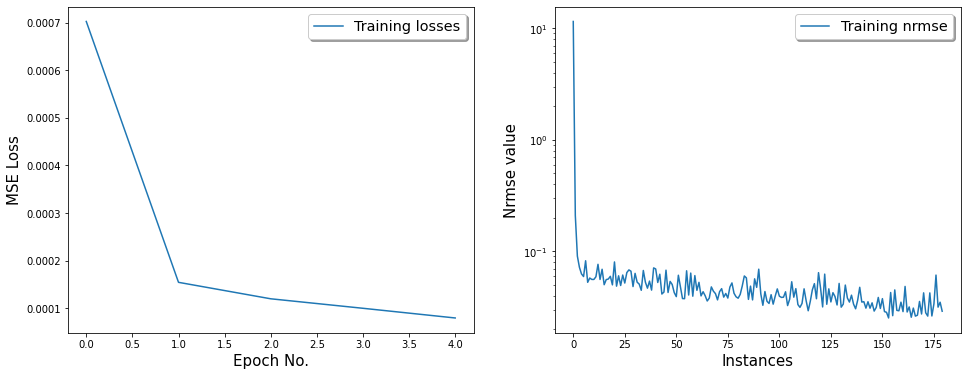

In [17]:
epochs = 5#optimized to find the minima of validation error
model_T2_image = Network(basis_K = K*2)
[losses_train2,nrmse_losses2] = training(model_T2_image,epochs,lr,batch_size,Training_input,Training_output_T2_image)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(losses_train2,label='Training losses')
#plt.plot(losses_valid,label='validation losses')
plt.xlabel('Epoch No.',fontsize=15)
plt.ylabel('MSE Loss',fontsize=15)
plt.legend(loc='best', shadow=True, fontsize='x-large')

plt.subplot(1,2,2)
plt.plot(nrmse_losses2,label='Training nrmse')
plt.xlabel('Instances',fontsize=15)
plt.ylabel('Nrmse value',fontsize=15)
plt.yscale('log')
plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

100%|██████████| 5/5 [01:35<00:00, 19.12s/it]


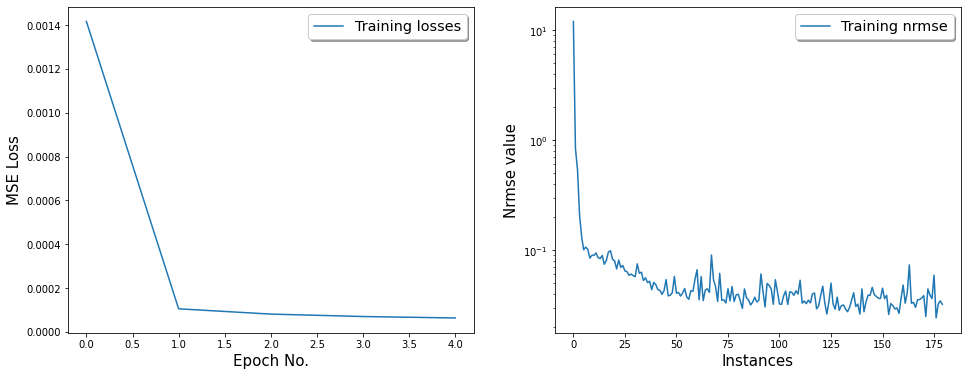

In [18]:
epochs = 5
model_T1_FLAIR = Network(basis_K = K*2)
[losses_train3,nrmse_losses3] = training(model_T1_FLAIR,epochs,lr,batch_size,Training_input,Training_output_T1_FLAIR)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(losses_train3,label='Training losses')
#plt.plot(losses_valid,label='validation losses')
plt.xlabel('Epoch No.',fontsize=15)
plt.ylabel('MSE Loss',fontsize=15)
plt.legend(loc='best', shadow=True, fontsize='x-large')

plt.subplot(1,2,2)
plt.plot(nrmse_losses3,label='Training nrmse')
plt.xlabel('Instances',fontsize=15)
plt.ylabel('Nrmse value',fontsize=15)
plt.yscale('log')
plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

100%|██████████| 5/5 [01:35<00:00, 19.03s/it]


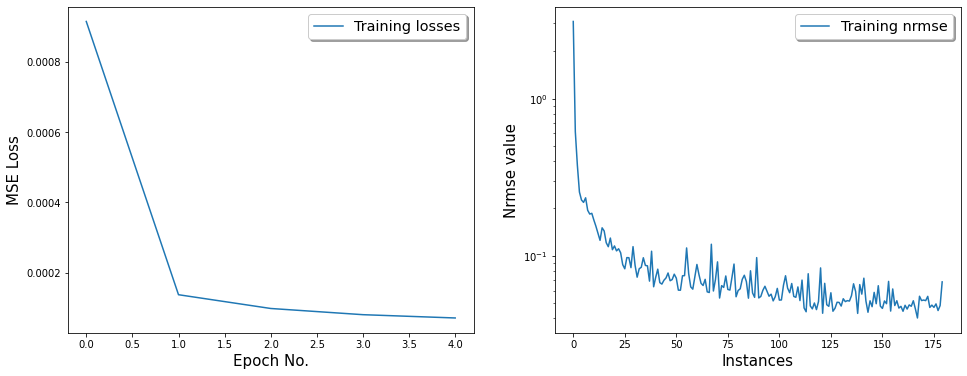

In [19]:
epochs = 5
model_T2_FLAIR = Network(basis_K = K*2)
[losses_train4,nrmse_losses4] = training(model_T2_FLAIR,epochs,lr,batch_size,Training_input,Training_output_T2_FLAIR)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(losses_train4,label='Training losses')
#plt.plot(losses_valid,label='validation losses')
plt.xlabel('Epoch No.',fontsize=15)
plt.ylabel('MSE Loss',fontsize=15)
plt.legend(loc='best', shadow=True, fontsize='x-large')

plt.subplot(1,2,2)
plt.plot(nrmse_losses4,label='Training nrmse')
plt.xlabel('Instances',fontsize=15)
plt.ylabel('Nrmse value',fontsize=15)
plt.yscale('log')
plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

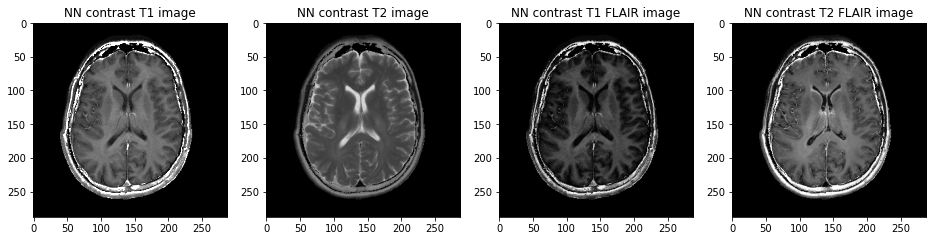

Learned output images by the NN


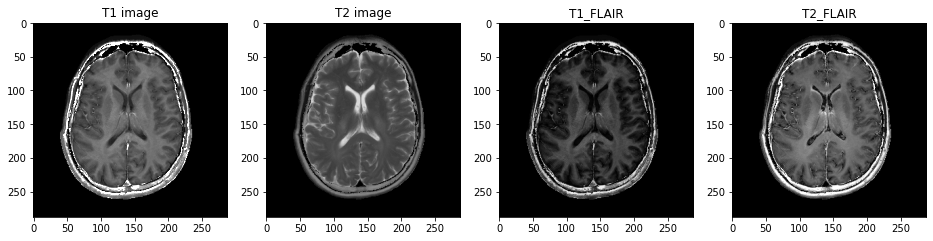

Training set output images for the neural network


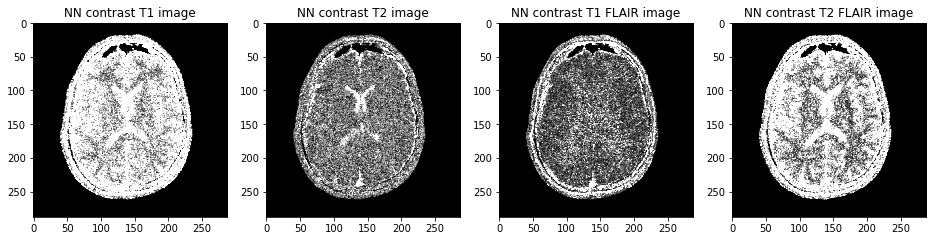

Difference Images (on 1/100 scale)
T1 image nrmse:- 0.04912738720452773
T2 image nrmse:- 0.025495502891734783
T1 FLAIR nrmse:- 0.031133583055163852
T2 FLAIR nrmse:- 0.038504772667950264


In [20]:
output1 = model_T1_image(Training_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() # - Training_output_T1_image.detach().numpy().squeeze() 
Im_synthetic[np.nonzero(mask)] = np.abs((ttt[:,0] + 1j*ttt[:,1]))#*amplitude_AA
NN_T1_image_learnt = Im_synthetic

output1 = model_T2_image(Training_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() #- Training_output_T2_image.detach().numpy().squeeze() 
Im_synthetic[np.nonzero(mask)] = np.abs((ttt[:,0] + 1j*ttt[:,1]))#*amplitude_AA
NN_T2_image_learnt = Im_synthetic

output1 = model_T1_FLAIR(Training_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() #- Training_output_T1_FLAIR.detach().numpy().squeeze()
Im_synthetic[np.nonzero(mask)] = np.abs((ttt[:,0] + 1j*ttt[:,1]))#*amplitude_AA
NN_T1_FLAIR_learnt = Im_synthetic


output1 = model_T2_FLAIR(Training_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze()# - Training_output_T2_FLAIR.detach().numpy().squeeze()
Im_synthetic[np.nonzero(mask)] = np.abs((ttt[:,0] + 1j*ttt[:,1]))#*amplitude_AA
NN_T2_FLAIR_learnt = Im_synthetic


plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image_learnt),cmap=plt.get_cmap('gray'), vmin=0, vmax=.5)
plt.title('NN contrast T1 image')

plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image_learnt),cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title('NN contrast T2 image')

plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR_learnt),cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title('NN contrast T1 FLAIR image')

plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR_learnt),cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('NN contrast T2 FLAIR image')
plt.show()
print('Learned output images by the NN')


plt.figure(figsize=(16,12))
Im_synthetic = np.zeros([288,288])
ttt = Training_output_T1_image.detach().numpy().squeeze() 
Im_synthetic[np.nonzero(mask)] = np.abs((ttt[:,0] + 1j*ttt[:,1]))#*A_magnitude
NN_T1_image = Im_synthetic
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('T1 image')

Im_synthetic = np.zeros([288,288])
ttt = Training_output_T2_image.detach().numpy().squeeze() 
Im_synthetic[np.nonzero(mask)] = np.abs((ttt[:,0] + 1j*ttt[:,1]))#*A_magnitude
NN_T2_image = Im_synthetic
plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image),cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title('T2 image')

Im_synthetic = np.zeros([288,288])
ttt = Training_output_T1_FLAIR.detach().numpy().squeeze()
Im_synthetic[np.nonzero(mask)] = np.abs((ttt[:,0] + 1j*ttt[:,1]))#*A_magnitude
NN_T1_FLAIR = Im_synthetic
plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title('T1_FLAIR')

Im_synthetic = np.zeros([288,288])
ttt = Training_output_T2_FLAIR.detach().numpy().squeeze()
Im_synthetic[np.nonzero(mask)] = np.abs((ttt[:,0] + 1j*ttt[:,1]))#*A_magnitude
NN_T2_FLAIR = Im_synthetic
plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('T2_FLAIR')

plt.show()

print('Training set output images for the neural network')

plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image - NN_T1_image_learnt),cmap=plt.get_cmap('gray'), vmin=0, vmax=.5*.01)
plt.title('NN contrast T1 image')

plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image - NN_T2_image_learnt),cmap=plt.get_cmap('gray'), vmin=0, vmax=1*.01)
plt.title('NN contrast T2 image')

plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR - NN_T1_FLAIR_learnt),cmap=plt.get_cmap('gray'), vmin=0, vmax=1*.01)
plt.title('NN contrast T1 FLAIR image')

plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR - NN_T2_FLAIR_learnt),cmap=plt.get_cmap('gray'), vmin=0, vmax=.5*.01)
plt.title('NN contrast T2 FLAIR image')
plt.show()
print('Difference Images (on 1/100 scale)')

print('T1 image nrmse:-', nrmse(NN_T1_image_learnt,NN_T1_image))
print('T2 image nrmse:-', nrmse(NN_T2_image_learnt,NN_T2_image))
print('T1 FLAIR nrmse:-', nrmse(NN_T1_FLAIR_learnt,NN_T1_FLAIR))
print('T2 FLAIR nrmse:-', nrmse(NN_T2_FLAIR_learnt,NN_T2_FLAIR))

In [51]:
nrmse( model_T2_image(Training_input).detach().numpy().squeeze(), Training_output_T2_image.detach().numpy().squeeze())

0.02937206

In [21]:
# #saving the network for basis 3 of seimens scanner sequence
# #save the network otherwise it takes a lot of time
# torch.save(model_T1_image.state_dict(),'32ETLmodel_T1_image_cplx_basis{}.pt'.format(K))
# torch.save(model_T2_image.state_dict(),'32ETLmodel_T2_image_cplx_basis{}.pt'.format(K))
# torch.save(model_T1_FLAIR.state_dict(),'32ETLmodel_T1_FLAIR_cplx_basis{}.pt'.format(K))
# torch.save(model_T2_FLAIR.state_dict(),'32ETLmodel_T2_FLAIR_cplx_basis{}.pt'.format(K))

# Fitting the experimental data

In [41]:
#loading the relevant data variables corresponding to the original basis
#data from the experimental readings
recon1 = np.load('estimated_subject2_96ETL_recon1.npy')
fully_image1 = np.load('estimated_subject2_96ETL_Fully_sampled_image1.npy')
pics_out_coeffs1 = np.load('estimated_subject2_96ETL_pics_out_coeffs1.npy')

#GT_coeff_img = np.load('GT_coeff_img.npy')
print('recon1 shape: ',recon1.shape, 'data type: ', recon1.dtype)
print('fully_image1 shape:', fully_image1.shape, 'data type: ',fully_image1.dtype)
print('pics_out_coeffs shape:',pics_out_coeffs1.shape, 'data type: ',pics_out_coeffs1.dtype)

recon1 shape:  (288, 288, 5) data type:  complex64
fully_image1 shape: (288, 288, 5) data type:  complex64
pics_out_coeffs shape: (288, 288, 5) data type:  complex64


In [42]:
AA = fully_image1[:,:,:K].reshape((288*288,K))
#AA = (fully_image1[:,:,:K]/PD_map[:,:,None]).reshape((288*288,K))
#AA = np.nan_to_num(AA,nan=0, posinf=0, neginf=0)
print(AA.shape)
max_val = np.max(np.abs(AA))
AA_norm = AA/np.max(np.abs(AA))#/np.amax(abs(AA),axis=1)[:,None]
Test_input = torch.from_numpy(np.concatenate((np.real(AA_norm),np.imag(AA_norm)),axis=1)).float()
print(max_val)

(82944, 5)
0.0035680637


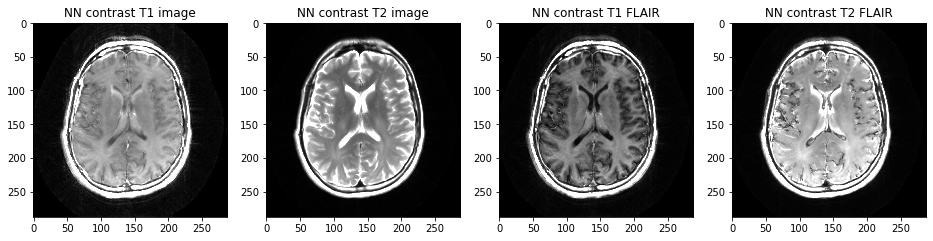

Fully sampled NN (complex) images


In [43]:
output1 = model_T1_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_image = Im_synthetic*max_val


output1 = model_T2_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_image = Im_synthetic*max_val


output1 = model_T1_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_FLAIR = Im_synthetic*max_val



output1 = model_T2_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_FLAIR = Im_synthetic*max_val

plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= 0.0003)
plt.title('NN contrast T1 image')
plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= 0.0005)
plt.title('NN contrast T2 image')
plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= 0.0005)
plt.title('NN contrast T1 FLAIR')
plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= 0.0003)
plt.title('NN contrast T2 FLAIR')
plt.show()
print('Fully sampled NN (complex) images')

In [44]:
True_contrast_T1_FLAIR = np.load('48ETL_semc_True_contrast_T1_FLAIR.npy')
True_contrast_T2_FLAIR = np.load('48ETL_semc_True_contrast_T2_FLAIR.npy')
True_contrast_T1_image = np.load('48ETL_semc_True_contrast_T1_image.npy')
True_contrast_T2_image = np.load('48ETL_semc_True_contrast_T2_image.npy')

In [49]:
print(nrmse(np.abs(NN_T1_image),True_contrast_T1_image))
print(nrmse(np.abs(NN_T2_image),True_contrast_T1_image))
print(nrmse(np.abs(NN_T1_FLAIR),True_contrast_T1_FLAIR))
print(nrmse(np.abs(NN_T2_FLAIR),True_contrast_T2_FLAIR))

0.38780574138890306
0.6003675264195066
0.33082092730299295
0.3619320242060163


In [27]:
AA = recon1[:,:,:K].reshape((288*288,K))
amplitude_AA = np.amax(abs(AA),axis=1)
AA_norm = AA#/np.amax(abs(AA),axis=1)[:,None]
Test_input = torch.from_numpy(np.concatenate((np.real(AA_norm),np.imag(AA_norm)),axis=1)).float()

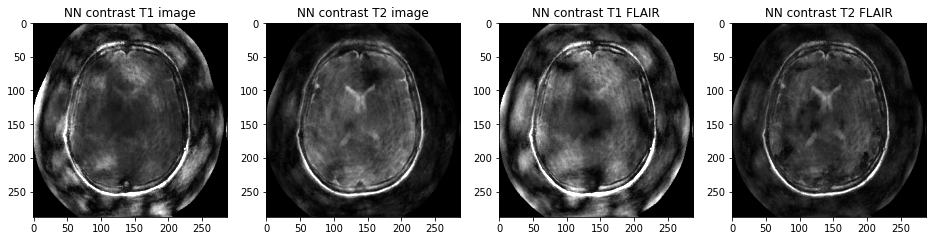

Reconstructed NN (complex) images


In [28]:
output1 = model_T1_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]*1000
NN_T1_image = Im_synthetic


output1 = model_T2_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]*1000
NN_T2_image = Im_synthetic


output1 = model_T1_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]*1000
NN_T1_FLAIR = Im_synthetic



output1 = model_T2_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]*1000
NN_T2_FLAIR = Im_synthetic

plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= 0.001)
plt.title('NN contrast T1 image')
plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T2 image')
plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T1 FLAIR')
plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T2 FLAIR')
plt.show()
print('Reconstructed NN (complex) images')

In [29]:
AA = pics_out_coeffs1[:,:,:K].reshape((288*288,K))
AA[np.abs(AA)<5e-05] = 0

#amplitude_AA = np.amax(abs(AA),axis=1)
AA_norm = AA#/np.amax(abs(AA),axis=1)[:,None]
AA_norm[np.isnan(AA_norm)] = 0

Test_input = torch.from_numpy(np.concatenate((np.real(AA_norm),np.imag(AA_norm)),axis=1)).float()

Test_input[np.isnan(Test_input)] = 0

<ipython-input-29-0ada9288647f>:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/aten/src/ATen/native/IndexingUtils.h:25.)
  Test_input[np.isnan(Test_input)] = 0


(82944, 5)


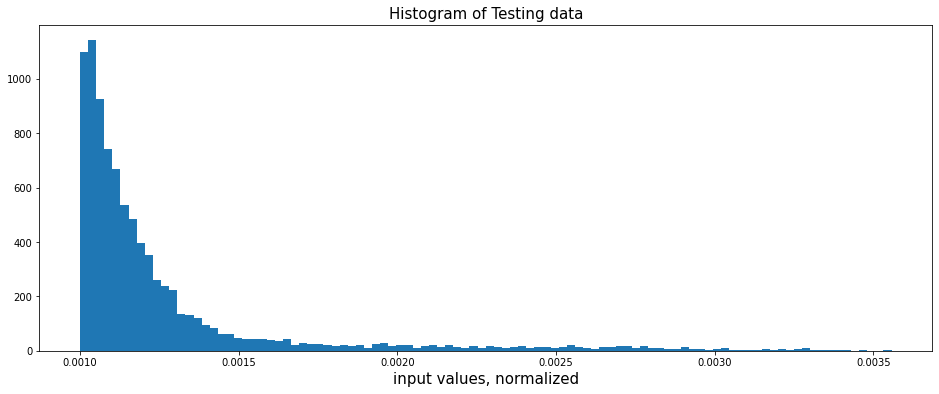

In [30]:
print(AA_norm.shape)

hist_data3 = np.abs(AA_norm.reshape((82944*5)))
hist_data3 = hist_data3[hist_data3<0.9e-0]
plt.figure(figsize=(16, 6))
plt.hist(hist_data3[hist_data3>1e-3], 100)#T1 values
plt.title('Histogram of Testing data',fontsize=15)
plt.xlabel('input values, normalized',fontsize=15)
plt.show()

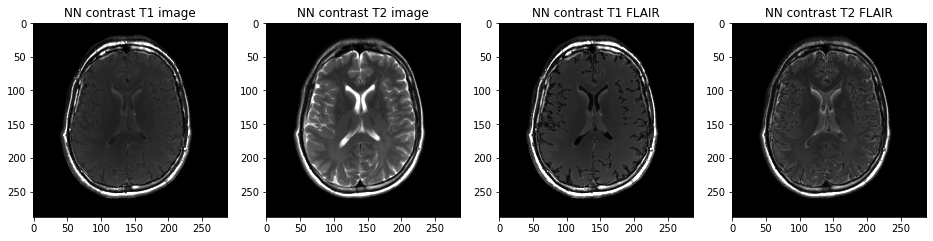

NN (complex) images generated from pics out coeffs


In [31]:
output1 = model_T1_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_image = Im_synthetic


output1 = model_T2_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_image = Im_synthetic


output1 = model_T1_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_FLAIR = Im_synthetic



output1 = model_T2_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_FLAIR = Im_synthetic

plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T1 image')
plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T2 image')
plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T1 FLAIR')
plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T2 FLAIR')
plt.show()
print('NN (complex) images generated from pics out coeffs')

# Below cells information
Now doing the testing for the data of subject 3, remember the NN are trained for the data of only the subject 1

In [32]:
#loading the relevant data variables corresponding to the original basis
#data from the experimental readings
recon1 = np.load('estimated_subject3_96ETL_recon1.npy')
fully_image1 = np.load('estimated_subject3_96ETL_Fully_sampled_image1.npy')
pics_out_coeffs1 = np.load('estimated_subject3_96ETL_pics_out_coeffs1.npy')

#GT_coeff_img = np.load('GT_coeff_img.npy')
print('recon1 shape: ',recon1.shape, 'data type: ', recon1.dtype)
print('fully_image1 shape:', fully_image1.shape, 'data type: ',fully_image1.dtype)
print('pics_out_coeffs shape:',pics_out_coeffs1.shape, 'data type: ',pics_out_coeffs1.dtype)

recon1 shape:  (288, 288, 5) data type:  complex64
fully_image1 shape: (288, 288, 5) data type:  complex64
pics_out_coeffs shape: (288, 288, 5) data type:  complex64


In [33]:
AA = fully_image1[:,:,:K].reshape((288*288,K))
#AA[np.abs(AA)<5e-05] = 0
print(AA.shape)
#print(AA[0,0])
amplitude_AA = np.amax(abs(AA),axis=1)
AA_norm = AA#/np.amax(abs(AA),axis=1)[:,None]
Test_input = torch.from_numpy(np.concatenate((np.real(AA_norm),np.imag(AA_norm)),axis=1)).float()
#print(AA[0,0])
print(AA[50*288 + 150,:])
#print(amplitude_AA[0])
#Test_input[np.isnan(Test_input)] = 0

print(Test_input[50*288 + 50,:])

(82944, 5)
[-1.8815327e-03+3.2885774e-04j -1.8769699e-04+3.5498957e-05j
  3.8928891e-04-5.1746978e-05j  9.6776588e-05+1.3917339e-08j
  3.4311586e-05-7.7865634e-06j]
tensor([-2.3161e-06,  1.1355e-07,  5.8891e-06, -1.1168e-05,  5.6849e-06,
         5.0511e-06, -6.4778e-06, -7.0878e-07,  5.2130e-07, -2.3805e-06])


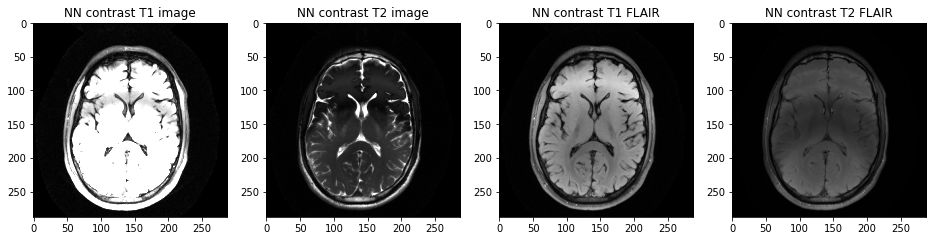

Fully sampled NN (complex) images


In [34]:
output1 = model_T1_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_image = Im_synthetic


output1 = model_T2_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_image = Im_synthetic


output1 = model_T1_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_FLAIR = Im_synthetic



output1 = model_T2_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_FLAIR = Im_synthetic

plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .00051)
plt.title('NN contrast T1 image')
plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .0005)
plt.title('NN contrast T2 image')
plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T1 FLAIR')
plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T2 FLAIR')
plt.show()
print('Fully sampled NN (complex) images')

In [35]:
AA = pics_out_coeffs1[:,:,:K].reshape((288*288,K))
AA[np.abs(AA)<5e-05] = 0

#amplitude_AA = np.amax(abs(AA),axis=1)
AA_norm = AA#/np.amax(abs(AA),axis=1)[:,None]
AA_norm[np.isnan(AA_norm)] = 0

Test_input = torch.from_numpy(np.concatenate((np.real(AA_norm),np.imag(AA_norm)),axis=1)).float()

Test_input[np.isnan(Test_input)] = 0

<ipython-input-35-0ada9288647f>:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/aten/src/ATen/native/IndexingUtils.h:25.)
  Test_input[np.isnan(Test_input)] = 0


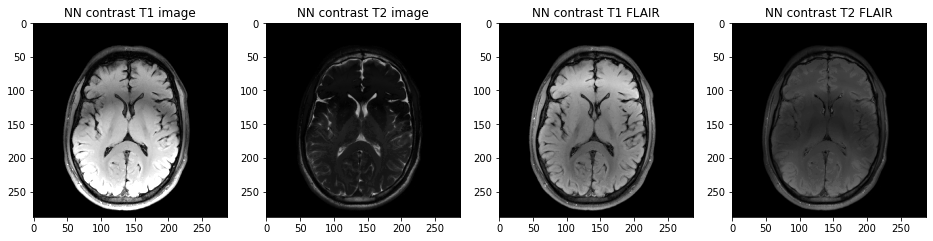

NN (complex) images generated from pics out coeffs


In [36]:
output1 = model_T1_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_image = Im_synthetic


output1 = model_T2_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_image = Im_synthetic


output1 = model_T1_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_FLAIR = Im_synthetic



output1 = model_T2_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_FLAIR = Im_synthetic

plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T1 image')
plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T2 image')
plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T1 FLAIR')
plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T2 FLAIR')
plt.show()
print('NN (complex) images generated from pics out coeffs')

(82944, 5)


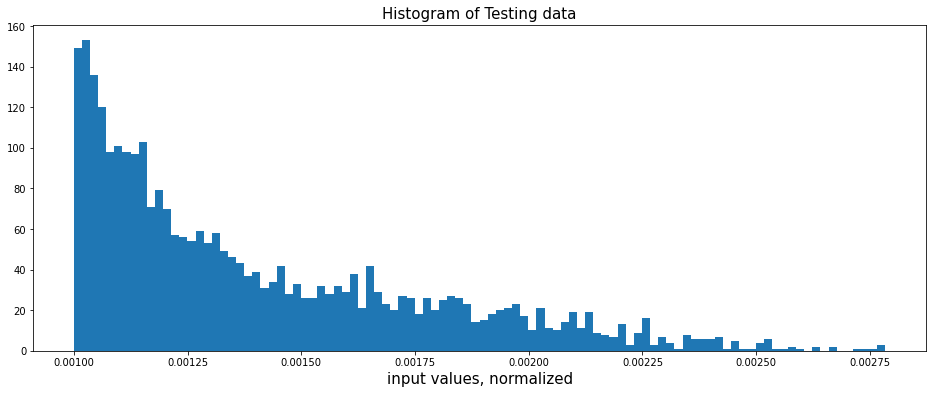

In [37]:
print(AA_norm.shape)

hist_data3 = np.abs(AA_norm.reshape((82944*5)))
hist_data3 = hist_data3[hist_data3<0.9e-0]
plt.figure(figsize=(16, 6))
plt.hist(hist_data3[hist_data3>1e-3], 100)#T1 values
plt.title('Histogram of Testing data',fontsize=15)
plt.xlabel('input values, normalized',fontsize=15)
plt.show()

# Doing testing for the subject 1

In [38]:
# import os
# print(os.getcwd())#get current working directory
# os.chdir('/home/ubuntu/sid_notebooks/subject2')#change current working directory
# print(os.getcwd())

In [39]:
# import os
# print(os.getcwd())#get current working directory
# os.chdir('/home/ubuntu/sid_notebooks/')#change current working directory
# print(os.getcwd())

In [40]:
#loading the relevant data variables corresponding to the original basis
#data from the experimental readings
recon1 = np.load('estimated_subject1_96ETL_recon1.npy')
fully_image1 = np.load('estimated_subject1_96ETL_Fully_sampled_image1.npy')
pics_out_coeffs1 = np.load('estimated_subject1_96ETL_pics_out_coeffs1.npy')

#GT_coeff_img = np.load('GT_coeff_img.npy')
print('recon1 shape: ',recon1.shape, 'data type: ', recon1.dtype)
print('fully_image1 shape:', fully_image1.shape, 'data type: ',fully_image1.dtype)
print('pics_out_coeffs shape:',pics_out_coeffs1.shape, 'data type: ',pics_out_coeffs1.dtype)

FileNotFoundError: [Errno 2] No such file or directory: 'estimated_subject1_96ETL_recon1.npy'

In [ ]:
AA = fully_image1[:,:,:K].reshape((288*288,K))
#AA[np.abs(AA)<5e-05] = 0
print(AA.shape)
#print(AA[0,0])
amplitude_AA = np.amax(abs(AA),axis=1)
AA_norm = AA#/np.amax(abs(AA),axis=1)[:,None]
#AA_norm[np.isnan(AA_norm)] = 0
Test_input = torch.from_numpy(np.concatenate((np.real(AA_norm),np.imag(AA_norm)),axis=1)).float()
#print(AA[0,0])
print(AA[50*288 + 150,:])
#print(amplitude_AA[0])
#Test_input[np.isnan(Test_input)] = 0

print(Test_input[50*288 + 50,:])

In [ ]:
output1 = model_T1_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_image = Im_synthetic


output1 = model_T2_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_image = Im_synthetic


output1 = model_T1_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_FLAIR = Im_synthetic



output1 = model_T2_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_FLAIR = Im_synthetic

plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T1 image')
plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T2 image')
plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T1 FLAIR')
plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .001)
plt.title('NN contrast T2 FLAIR')
plt.show()
print('Fully sampled NN (complex) images')

In [ ]:
AA = pics_out_coeffs1[:,:,:K].reshape((288*288,K))
AA[np.abs(AA)<5e-05] = 0

#amplitude_AA = np.amax(abs(AA),axis=1)
AA_norm = AA#/np.amax(abs(AA),axis=1)[:,None]
AA_norm[np.isnan(AA_norm)] = 0

Test_input = torch.from_numpy(np.concatenate((np.real(AA_norm),np.imag(AA_norm)),axis=1)).float()

Test_input[np.isnan(Test_input)] = 0

In [ ]:
output1 = model_T1_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_image = Im_synthetic


output1 = model_T2_image(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_image = Im_synthetic


output1 = model_T1_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T1_FLAIR = Im_synthetic



output1 = model_T2_FLAIR(Test_input)
Im_synthetic = np.zeros([288,288])
ttt = output1.detach().numpy().squeeze() 
image_data = (ttt[:,0] + 1j*ttt[:,1])#*amplitude_AA
Im_synthetic = image_data.reshape((288,288))
#Im_synthetic = Im_synthetic*porton_image_data[:,:,slice_index]
NN_T2_FLAIR = Im_synthetic

plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(NN_T1_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .0003)
plt.title('NN contrast T1 image')
plt.subplot(1,4,2)
plt.imshow(np.abs(NN_T2_image),cmap=plt.get_cmap('gray'), vmin=0, vmax= .0005)
plt.title('NN contrast T2 image')
plt.subplot(1,4,3)
plt.imshow(np.abs(NN_T1_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .0003)
plt.title('NN contrast T1 FLAIR')
plt.subplot(1,4,4)
plt.imshow(np.abs(NN_T2_FLAIR),cmap=plt.get_cmap('gray'), vmin=0, vmax= .0003)
plt.title('NN contrast T2 FLAIR')
plt.show()
print('NN (complex) images generated from pics out coeffs')

In [ ]:
print(AA_norm.shape)

hist_data3 = np.abs(AA_norm.reshape((82944*5)))
hist_data3 = hist_data3[hist_data3<0.9e-0]
plt.figure(figsize=(16, 6))
plt.hist(hist_data3[hist_data3>1e-3], 100)#T1 values
plt.title('Histogram of Testing data',fontsize=15)
plt.xlabel('input values, normalized',fontsize=15)
plt.show()